# Importing general libraries

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
#from tqdm import tnrange, tqdm_notebook

# Loading Data

In [4]:
#df = pd.read_csv('tweets_public_spanish.csv', index_col='tweet_id', encoding='utf-16')
df = pd.read_csv('tweets_public_spanish.csv', index_col='tweet_id', sep=',')
y = LabelEncoder().fit_transform(df['airline_sentiment'].values)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 926419989107798016 to 935546571663527936
Data columns (total 9 columns):
airline_sentiment    7867 non-null object
is_reply             7867 non-null bool
reply_count          7867 non-null int64
retweet_count        7867 non-null int64
text                 7867 non-null object
tweet_coord          20 non-null object
tweet_created        7867 non-null object
tweet_location       419 non-null object
user_timezone        5100 non-null object
dtypes: bool(1), int64(2), object(6)
memory usage: 560.8+ KB


In [6]:
ini_num_tweets = len(df.text)

In [7]:
df.columns

Index(['airline_sentiment', 'is_reply', 'reply_count', 'retweet_count', 'text',
       'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
# Removing useless columns
df.drop(['reply_count','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'], axis=1, inplace=True)

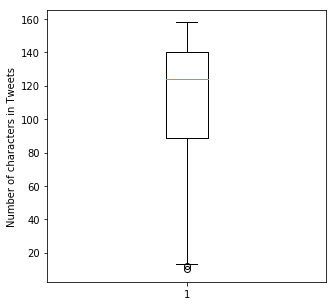

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot([len(t) for t in df.text])
plt.ylabel('Number of characters in Tweets')
plt.show()

In [10]:
# clearly some tweets exceed the twitter’s character limit that used to be 140.

print('Number of tweets with more than 140 characters: {}'.format(len(df[np.array([len(t) for t in df.text]) > 140])))

print(df[np.array([len(t) for t in df.text]) > 140].text.values)

Number of tweets with more than 140 characters: 10
[ 'Nueva rutina de vuelo: embarcas&gt; te abrochas el cinturón&gt;paran el avion&gt; bajate y montate en otro&gt; que divertida experiencia 🎉 @Ryanair'
 '@kerynha @Iberia Qué cabrones... Supongo que les habrás puesto una reclamación. A ver si consigues algo. Ánimo y mucha suerte!! &lt;3&lt;3&lt;3'
 '@Iberia 6000 avios y 100 euros. Cuando el billete valía 190 euros. Eso es cash&amp;avios o avios&amp;money? Porque 100 euro… https://t.co/XTvRa6mJJT'
 'Curiosidades....  Madrid&lt;&gt;Barcelona en avión en 1927 = las 163 pesetas que costó el primer billete de Iberia... https://t.co/wtE2M1Jt3o'
 'Iberia inaugura un nuevo espacio Premium para sentirte como una reina o un rey  &lt;html&gt;\n&lt;head&gt;&lt;title&gt;301 Moved Perma… https://t.co/N8f1VKa29S'
 '@Iberia Hola les escribo desde Mexico de una agencia de viajes necesito de su apoyo ya q el portal de Iberia &lt; fact… https://t.co/uh8gytyOkh'
 '@Iberia DEBERÍA BLOQUEARTE. PERO NO: ME D

In [11]:
# Clearly there is some HTML encoding that you will need to remove during cleaning

# Class imbalance
   + There is an important imbalance:
       + Whenever is possible you will consider **class weigths**
       + Also will consider **oversampling techniques**

Counter({'negative': 3769, 'neutral': 2609, 'positive': 1489}) 



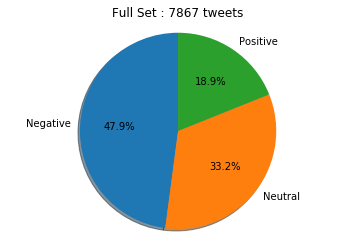

In [12]:
print(Counter(df.airline_sentiment),'\n')

c = Counter(y)
plt.pie([i[1] / len(y) * 100.0 for i in c.most_common()], labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') 
plt.title('Full Set : {} tweets'.format(len(y)))
plt.show()

# Data Cleaning
   + HTML encoding
   + Removing characters like Hashtags
   + Removing numbers and special characters
   + Contraction check (for english text, e.g. ain't == is not etc)

In [13]:
# need to do emoji substitution before cleaning

In [14]:
import codecs
import unidecode
import re
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stopwordlist = set(stopwords.words("spanish"))
nlp = spacy.load('es')
sbstemmer = SnowballStemmer('spanish')

def tweet_cleaner(text, lemmatize = False, stemming = False):
    # if you select to to lemmatization you will consider spacy tool
    # for stemming will consider snowball 
    
    #print(text)
            
    apostrophe_handled = re.sub("’", "'", text)
    url_handled = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "", apostrophe_handled)
    puntuation_handled = re.sub('([.,!¿?()])', r' \1 ', url_handled)
    
    parsed = nlp(puntuation_handled)
    final_tokens = []

    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if lemmatize:
                if t.lemma_ == '-PRON-':
                    final_tokens.append(str(t).lower())
                    sc_removed = []
                else:
                    sc_removed = re.sub("[^a-zA-Záéíóúüñ]", "", str(t.lemma_).lower())           
            elif stemming :
                sc_removed = re.sub("[^a-zA-Záéíóúüñ]", "", str(sbstemmer.stem(str(t)).lower()))
            else:
                sc_removed = re.sub("[^a-zA-Záéíóúüñ]", "", str(t).lower())
                    
            if len(sc_removed) > 1:
                final_tokens.append(sc_removed)
                    
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined) # maximun 2 ocurrencies of any character in word
    return spell_corrected

In [15]:
df.text[18:19].values

array([ 'La mejor foto tecnológica del año 2017 https://t.co/c2gDhu1Fe3 #WomenInTechSpain #redhat @juliaberp_julia Red Hat Iberia Country Manager'], dtype=object)

In [16]:
[tweet_cleaner(t) for t in df.text[18:19].values]

['la mejor foto tecnológica del año womenintechspain redhat red hat iberia country manager']

In [17]:
[tweet_cleaner(t, lemmatize=True) for t in df.text[18:19].values]

['la mejor foto tecnológico del año womenintechspain redhat red hat iberia country manager']

In [18]:
[tweet_cleaner(t, stemming=True) for t in df.text[18:19].values]

['la mejor fot tecnolog del año womenintechspain redhat red hat iberi country manag']

In [19]:
df['cleaned_text'] = [tweet_cleaner(t) for t in df.text.values]
df['cleaned_text_and_lemmatization'] = [tweet_cleaner(t, lemmatize=True) for t in df.text.values]
df['cleaned_text_and_stemming'] = [tweet_cleaner(t, stemming=True) for t in df.text.values]
# removing duplicate tweets
df.drop_duplicates(subset=['cleaned_text'], inplace=True)
y = LabelEncoder().fit_transform(df['airline_sentiment'].values)

Counter({'negative': 3406, 'neutral': 2080, 'positive': 1165}) 



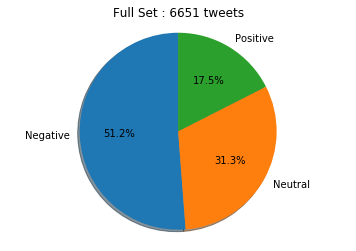

In [20]:
print(Counter(df.airline_sentiment),'\n')

c = Counter(df.airline_sentiment)
plt.pie([i[1] / len(y) * 100.0 for i in c.most_common()], labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') 
plt.title('Full Set : {} tweets'.format(len(y)))
plt.show()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6651 entries, 926419989107798016 to 943045386570223616
Data columns (total 6 columns):
airline_sentiment                 6651 non-null object
is_reply                          6651 non-null bool
text                              6651 non-null object
cleaned_text                      6651 non-null object
cleaned_text_and_lemmatization    6651 non-null object
cleaned_text_and_stemming         6651 non-null object
dtypes: bool(1), object(5)
memory usage: 318.3+ KB


In [22]:
print('There are {} repeated tweets (same text after cleaning but different id)'.format(ini_num_tweets - len(df.cleaned_text)))

There are 1216 repeated tweets (same text after cleaning but different id)


Number of tweets with more than 140 characters: 0


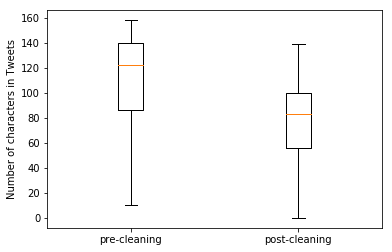

In [23]:
print('Number of tweets with more than 140 characters: {}'.format(len(df[np.array([len(t) for t in df.cleaned_text]) > 140])))

plt.boxplot([[len(t) for t in df.text], [len(t) for t in df.cleaned_text]])
plt.xticks([1,2],['pre-cleaning', 'post-cleaning'])
plt.ylabel('Number of characters in Tweets')
plt.show()

# Word Clouds

In [24]:
from wordcloud import WordCloud

Sentiment : negative


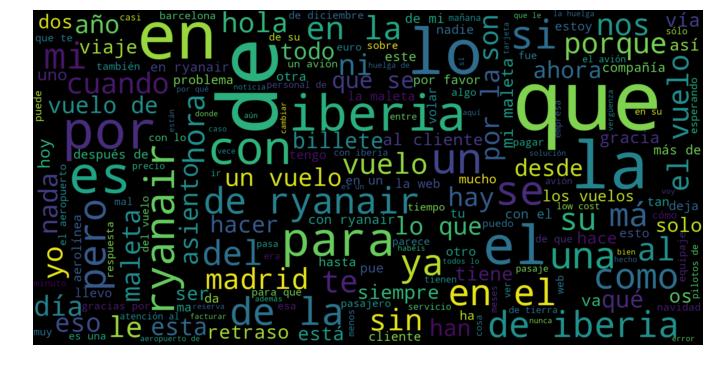

Sentiment : neutral


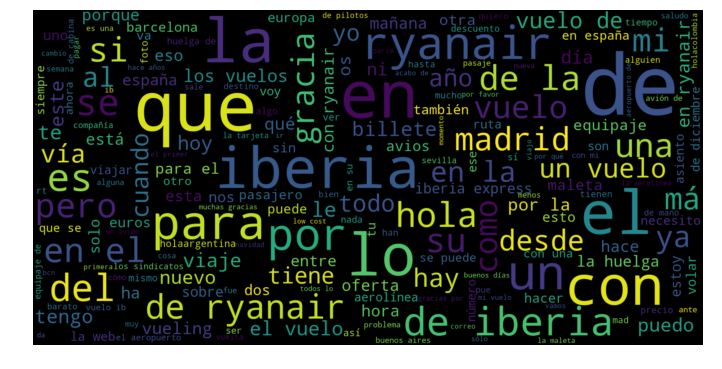

Sentiment : positive


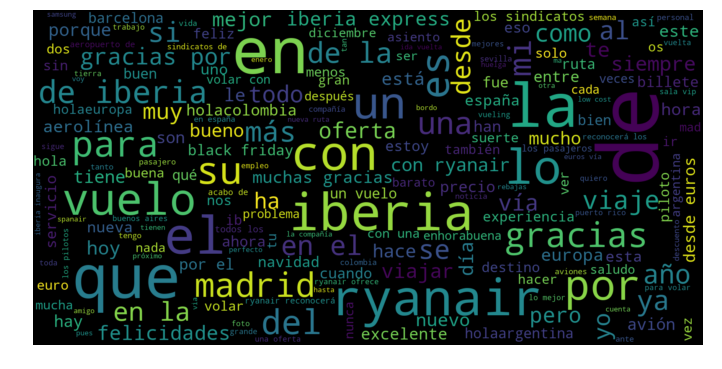

In [25]:
for sentiment in ['negative', 'neutral', 'positive']:

    print('Sentiment : ' + sentiment)

    tweets = df[df.airline_sentiment == sentiment]
    string = []
    for t in tweets.cleaned_text:
        string.append(t)
    string = pd.Series(string).str.cat(sep=' ')

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [26]:
# Pretty but not very informative

# Counting frequencies of words 
   * without stop words

In [27]:
from nltk.corpus import stopwords

stopwordlist = set(stopwords.words("spanish"))

cvec = CountVectorizer(stop_words=stopwords.words('spanish'))
cvec.fit(df.cleaned_text)

print('Size of corpus : ' + str(len(cvec.get_feature_names())))

neg_doc_matrix = cvec.transform(df[df.airline_sentiment == 'negative'].cleaned_text)
pos_doc_matrix = cvec.transform(df[df.airline_sentiment == 'positive'].cleaned_text)
neu_doc_matrix = cvec.transform(df[df.airline_sentiment == 'neutral'].cleaned_text)

neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neu_tf = np.sum(neu_doc_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neu = np.squeeze(np.asarray(neu_tf))

term_freq_df = pd.DataFrame([neg,neu,pos],columns=cvec.get_feature_names()).transpose()

term_freq_df.columns = ['negative', 'neutral', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['neutral'] + term_freq_df['positive']

Size of corpus : 11409


In [28]:
# printing 20 more frequent tokens per sentiment

from tabulate import tabulate

for sentiment in ['negative', 'neutral', 'positive']:
    print('\nSorted by ocurrencies in tweets with sentiment : ' + sentiment)
    print('\n',tabulate(term_freq_df.sort_values(by=sentiment, ascending=False).iloc[:20], headers=['negative', 'neutral', 'positive', 'total']))


Sorted by ocurrencies in tweets with sentiment : negative

             negative    neutral    positive    total
--------  ----------  ---------  ----------  -------
iberia           662        564         329     1555
ryanair          627        437         261     1325
vuelo            415        222          87      724
si               268        136          56      460
maleta           163         35           6      204
vuelos           148        134          92      374
avión            137         56          31      224
madrid           131        141          93      365
hacer            124         41          14      179
web              115         46           6      167
gracias          113        130         151      394
hola             112        131          16      259
horas            104         16          11      131
hace             103         55          27      185
maletas          101         12           2      115
huelga            99         62       

In [29]:
# still there are common words even in the top list per class

# Zipf’s Law in tweets

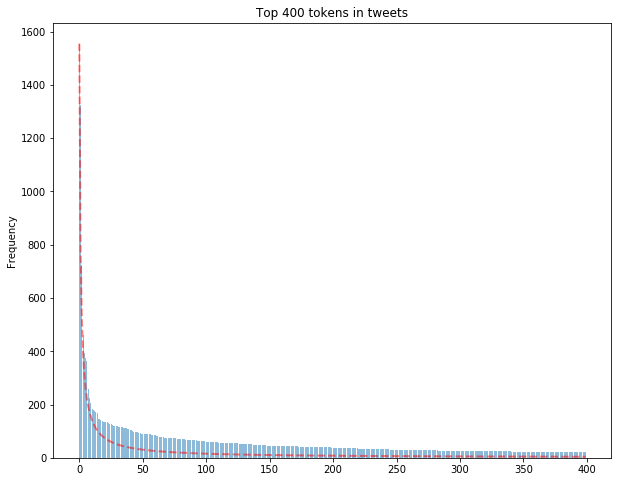

In [30]:
y_pos = np.arange(400)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:400], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 400 tokens in tweets')
plt.show()

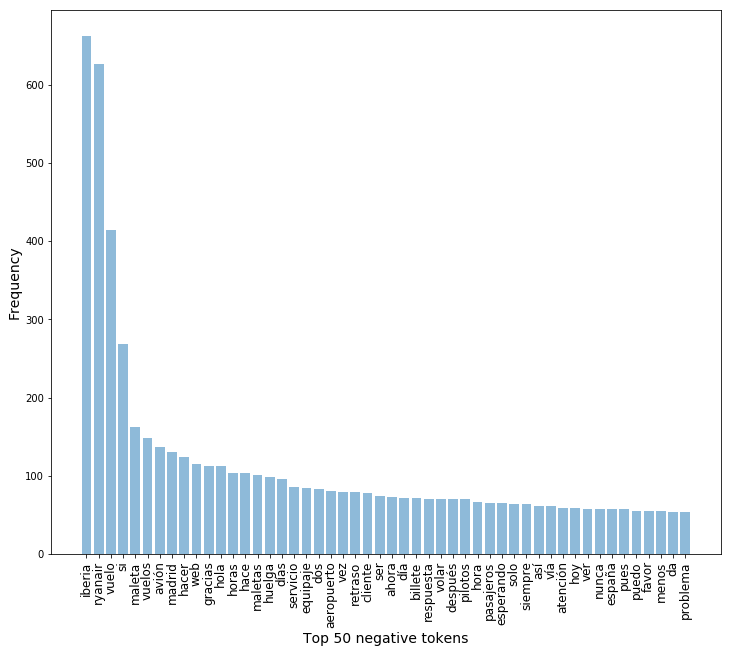

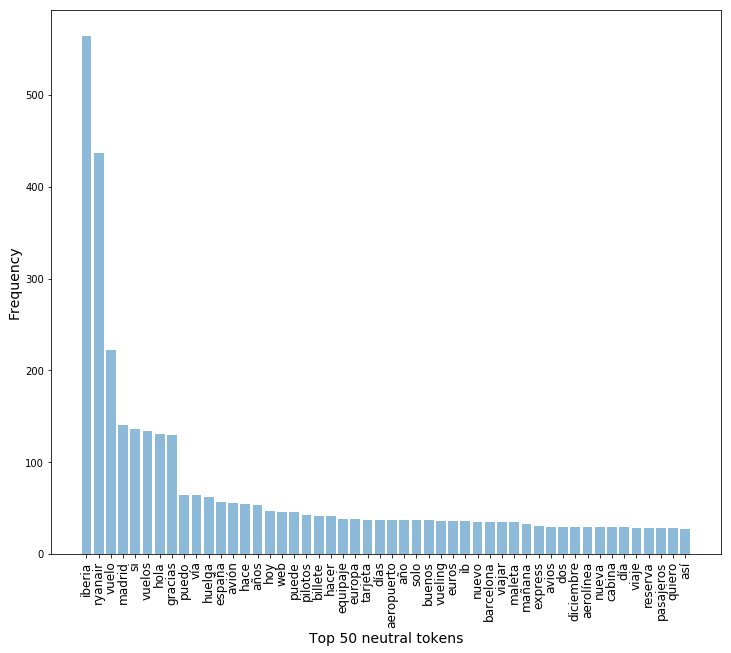

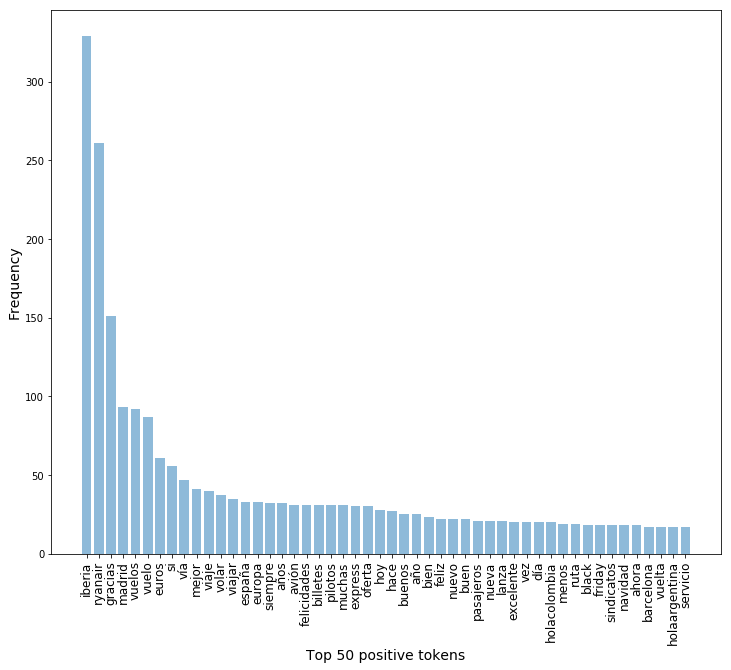

In [31]:
for sentiment in ['negative','neutral','positive']:
    
    y_pos = np.arange(50)
    plt.figure(figsize=(12,10))
    plt.bar(y_pos, term_freq_df.sort_values(by=sentiment, ascending=False)[sentiment][:50], align='center', alpha=0.5)
    plt.xticks(y_pos, term_freq_df.sort_values(by=sentiment, ascending=False)[sentiment][:50].index,
               rotation='vertical', fontsize=12)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlabel('Top 50 ' + sentiment + ' tokens', fontsize=14)
    plt.show()

Frequency is pretty low for most of tokens

Now will compare frequency of tokens in tweets according the sentiment, since there is a huge class imbalance we need to normalize some how instead of just considering number of occurencies

In [32]:
from scipy.stats import hmean, norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

# Doing for positive tweets
term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
#term_freq_df.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

# Doing for negative tweets
term_freq_df['neg_rate'] = term_freq_df['negative'] * 1./term_freq_df['total']
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] * 1./term_freq_df['negative'].sum()
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']]) if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)                                    
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])

term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,neutral,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
iberia,662,564,329,1555,0.211576,0.039610,0.066728,0.572255,1.0,0.727942,0.425723,0.024095,0.045608,0.401107,1.000000,0.572558
ryanair,627,437,261,1325,0.196981,0.031423,0.054200,0.553876,1.0,0.712896,0.473208,0.022821,0.043542,0.443526,1.000000,0.614504
gracias,113,130,151,394,0.383249,0.018180,0.034713,0.767602,1.0,0.868524,0.286802,0.004113,0.008109,0.285100,1.000000,0.443701
madrid,131,141,93,365,0.254795,0.011197,0.021451,0.625627,1.0,0.769706,0.358904,0.004768,0.009411,0.343442,1.000000,0.511287
vuelos,148,134,92,374,0.245989,0.011076,0.021198,0.614911,1.0,0.761542,0.395722,0.005387,0.010629,0.374863,1.000000,0.545310
vuelo,415,222,87,724,0.120166,0.010474,0.019269,0.456155,1.0,0.626520,0.573204,0.015105,0.029434,0.534403,1.000000,0.696561
euros,43,36,61,140,0.435714,0.007344,0.014445,0.815596,1.0,0.898433,0.307143,0.001565,0.003114,0.301078,0.999662,0.462777
si,268,136,56,460,0.121739,0.006742,0.012777,0.458150,1.0,0.628399,0.582609,0.009754,0.019187,0.542931,1.000000,0.703766
vía,61,64,47,172,0.273256,0.005659,0.011088,0.647773,1.0,0.786241,0.354651,0.002220,0.004413,0.339876,1.000000,0.507325
mejor,25,23,41,89,0.460674,0.004936,0.009768,0.836088,1.0,0.910728,0.280899,0.000910,0.001814,0.280540,0.970750,0.435285


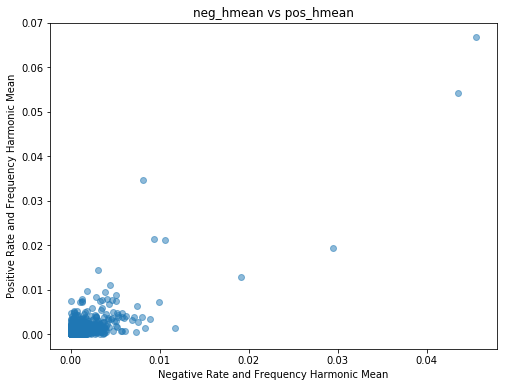

In [33]:
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')
plt.show()

Is hard to distinguish meaningful relations between negative and positive frequency of tweets

from bokeh.plotting import figure, output_file, save
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)

#show(p)

#output_file('neg_pos_tokens_bokeh.html', mode='inline')
#save(p)


# Splitting data into training and test set
   + Will use stratisfied splitting to ensure that classes are properly umbalanced also in the test set
   + Will use cross-validation all along the modeling process

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit 


for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text.values, y):
    text_train, text_test = df.cleaned_text.values[train_index], df.cleaned_text.values[test_index]
    y_train, y_test = y[train_index], y[test_index]    

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral and {3:.2f}% positive".format(len(text_train),
                                                            len(text_train[y_train == 0]) / (len(text_train)*1.)*100,
                                                            len(text_train[y_train == 1]) / (len(text_train)*1.)*100,
                                                            len(text_train[y_train == 2]) / (len(text_train)*1.)*100))

print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral and {3:.2f}% positive".format(len(text_test),
                                                            len(text_test[y_test == 0]) / (len(y_test)*1.)*100,
                                                            len(text_test[y_test == 1]) / (len(y_test)*1.)*100,
                                                            len(text_test[y_test == 2]) / (len(y_test)*1.)*100))

Train set has total 5320 entries with 51.20% negative, 31.28% neutral and 17.52% positive
Test set has total 1331 entries with 51.24% negative, 31.25% neutral and 17.51% positive


# Feature extraction

# Linear Regression as Baseline model 
   + Using LR as baseline model during feature extraction

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import mglearn
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt


def accuracy_summary(pipeline, x_train, y_train, x_test, y_test, n_splits=2):
    # Doing CV
    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
    val_data = cross_val_score(pipeline, x_train, y_train, cv=cv)
    accuracy_val = np.mean(val_data)
    # predict on the test set
    accuracy_test = accuracy_score(pipeline.fit(x_train, y_train).predict(x_test), y_test)
    return accuracy_val, accuracy_test


def nfeature_accuracy_checker(vectorizer=CountVectorizer(), n_features=np.arange(1000,20001,1000), 
                              stop_words=None, 
                              ngram_range=(1, 1), 
                              classifier=LogisticRegression(),
                              n_splits=2):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        #print("Validation result for {} features and K-fold of {}".format(n, n_splits))
        feature_accuracy_val, feature_accuracy_test = accuracy_summary(checker_pipeline, text_train, y_train, 
                                                     text_test, y_test,
                                                     n_splits = n_splits)
        result.append((n, feature_accuracy_val, feature_accuracy_test))
    return result


def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test, n_splits=2, param_grid={}):

    null_accuracy = len(x_test[y_test == 0]) / (len(y_test)*1.)  # negative class is the majority here
    
    # Doing CV
    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)

    grid = GridSearchCV(pipeline, param_grid, cv=cv, 
                    verbose=1, n_jobs=-1, refit=True)
    grid.fit(x_train, y_train)
    
    accuracy_val = grid.best_score_
    
    # predict on the test set training with full x_train
    y_pred = grid.predict(x_test)
    accuracy_test = accuracy_score(y_pred, y_test)

    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1,2]))
    confusion = pd.DataFrame(conmat, index=['negative', 'neutral', 'positive'],
                         columns=['predicted_negative', 'predicted_neutral', 'predicted_positive'])
    
    
    print("Best Parameters after tuning with gridsearch: {}".format(grid.best_params_))
    print("\nNull accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Mean accuracy score : {0:.2f}%".format(accuracy_val*100))
    print("accuracy in test set : {0:.2f}%".format(accuracy_test*100))

    if accuracy_val > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy_val-null_accuracy)*100))
    elif accuracy_val == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy_val)*100))
    
    print("-"*80)
    print("Confusion Matrix in Test Set\n")
    print(confusion)
    plt = plot_confusion_matrix(conmat, classes=['negative', 'neutral', 'positive'], normalize=False)
    plt.show()
    print("-"*80)
    print("Classification Report in Test Set\n")
    print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
    
    return grid
    
    
def plot_gridsearch_heatmap2D(grid, xticks, yticks):
    # extract scores from grid_search
    scores = grid.cv_results_['mean_test_score'].reshape(-1, len(param_grid[yticks])).T
    # visualize heat map
    heatmap = mglearn.tools.heatmap(
        scores, xlabel=xticks, ylabel=yticks, cmap="viridis", fmt="%.3f",
        xticklabels=param_grid[xticks],
        yticklabels=param_grid[yticks])
    plt.colorbar(heatmap)
    plt.show()
    
    
def accuracy_test_set(models, scores, X_train, y_train, X_test, y_test, threshold = 0.8):
    # consider model if avg accuracy > treshold
    print('Accuracy for the test set :\n')
    scores_test = []
    for score in scores:
        if score[1] >= threshold:
            model = dict(models)[score[0]]
            score_test = accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test)
            score_tupple = (score[0], score_test)
            scores_test.append(score_tupple)
    
    sorted_scores = sorted(scores_test, key=lambda x: -x[1])
    print (tabulate(sorted_scores, floatfmt=".3f", headers=("model", 'accuracy')))          

# Feature Extraction

   + Considering :
       + Stemming / Lemmatization
       + bag of words model
       + tf-idf
       + stop words
       
   
   + The final goal is to decide how to represent text

# NO Stemming / Lemmatization

In [36]:
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")

clas = LogisticRegression()
n_features = np.arange(1000,15000,1000)

feature_result_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features)
feature_result_no_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features, stop_words=stopwordlist)

custom_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:5].index))
feature_result_no_csw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features, stop_words=custom_stop_words)

# also tf-idf with stop words 
feature_result_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), classifier=clas, n_splits=5, n_features=n_features)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pe

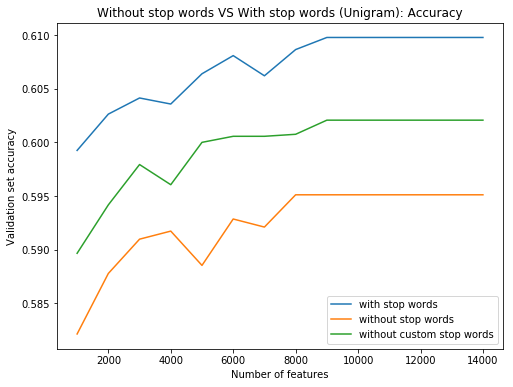

In [37]:
nfeatures_plot_sw = pd.DataFrame(feature_result_sw, columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_no_sw = pd.DataFrame(feature_result_no_sw, columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_no_csw = pd.DataFrame(feature_result_no_csw, columns=['nfeatures','validation_accuracy','test_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_sw.nfeatures, nfeatures_plot_sw.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_no_sw.nfeatures, nfeatures_plot_no_sw.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_no_csw.nfeatures, nfeatures_plot_no_csw.validation_accuracy,label='without custom stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.show()

Considering bigrams and trigrams

In [38]:
feature_result_bg_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), ngram_range=(1, 2), n_splits=5, n_features=n_features)
feature_result_tg_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), ngram_range=(1, 3), n_splits=5, n_features=n_features)

# doing for tf-idf also
feature_result_bg_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), ngram_range=(1, 2), n_splits=5, n_features=n_features)
feature_result_tg_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), ngram_range=(1, 3), n_splits=5, n_features=n_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solve

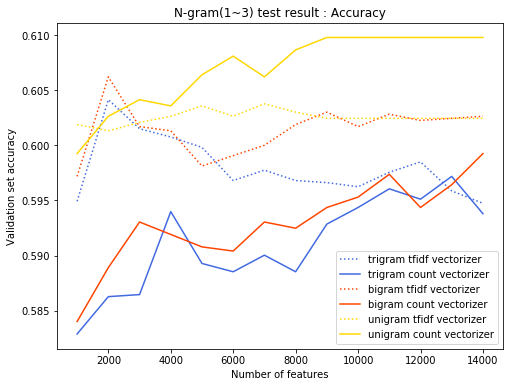

In [39]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg_sw,columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg_sw,columns=['nfeatures','validation_accuracy','test_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_sw,columns=['nfeatures','validation_accuracy','test_accuracy'])

nfeatures_plot_ug_tfidf = pd.DataFrame(feature_result_sw_tfidf,columns=['nfeatures','validation_accuracy','test_accuracy'])
nfeatures_plot_tg_tfidf = pd.DataFrame(feature_result_tg_sw_tfidf,columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_bg_tfidf = pd.DataFrame(feature_result_bg_sw_tfidf,columns=['nfeatures','validation_accuracy','test_accuracy'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg_tfidf.nfeatures, nfeatures_plot_tg_tfidf.validation_accuracy,label='trigram tfidf vectorizer',linestyle=':',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer', color='royalblue')
plt.plot(nfeatures_plot_bg_tfidf.nfeatures, nfeatures_plot_bg_tfidf.validation_accuracy,label='bigram tfidf vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',color='orangered')
plt.plot(nfeatures_plot_ug_tfidf.nfeatures, nfeatures_plot_ug_tfidf.validation_accuracy, label='unigram tfidf vectorizer',linestyle=':',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

**Curiously using bigrams or trigrams did not improve the scoring and neither tf-idf.**

In [40]:
nfeatures_plot_sw.sort_values(by='validation_accuracy', ascending=False)

,nfeatures,validation_accuracy,test_accuracy
8,9000,0.609774,0.596544
9,10000,0.609774,0.596544
10,11000,0.609774,0.594290
11,12000,0.609774,0.594290
12,13000,0.609774,0.594290
13,14000,0.609774,0.594290
7,8000,0.608647,0.595041
5,6000,0.608083,0.596544
4,5000,0.606391,0.596544
6,7000,0.606203,0.595041


According to this a maximun number of tokens as **9000** would be enough if using **unigrams** and **stopwords**

# Considering Stemming

In [41]:
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text.values, y):
    text_train, text_test = df.cleaned_text_and_stemming.values[train_index], df.cleaned_text_and_stemming.values[test_index]
    y_train, y_test = y[train_index], y[test_index]    

In [42]:
clas = LogisticRegression()
n_features = np.arange(1000,15000,1000)

feature_result_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features)
feature_result_no_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features, stop_words=stopwordlist)

custom_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:5].index))
feature_result_no_csw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features, stop_words=custom_stop_words)

# also tf-idf with stop words 
feature_result_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), classifier=clas, n_splits=5, n_features=n_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solve

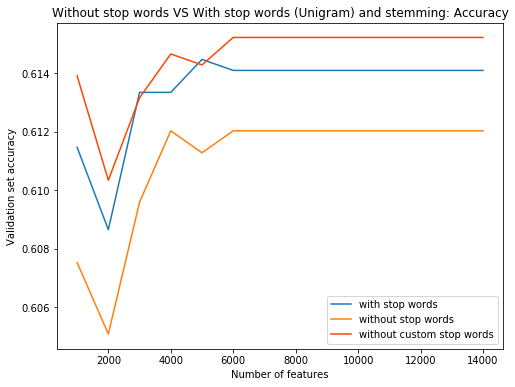

In [43]:
nfeatures_plot_sw = pd.DataFrame(feature_result_sw, columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_no_sw = pd.DataFrame(feature_result_no_sw, columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_no_csw = pd.DataFrame(feature_result_no_csw, columns=['nfeatures','validation_accuracy','test_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_sw.nfeatures, nfeatures_plot_sw.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_no_sw.nfeatures, nfeatures_plot_no_sw.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_no_csw.nfeatures, nfeatures_plot_no_csw.validation_accuracy,label='without custom stop words',color='orangered')

plt.title("Without stop words VS With stop words (Unigram) and stemming: Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.show()

In [44]:
nfeatures_plot_no_csw.sort_values(by='validation_accuracy', ascending=False)

,nfeatures,validation_accuracy,test_accuracy
5,6000,0.615226,0.596544
6,7000,0.615226,0.595793
7,8000,0.615226,0.595793
8,9000,0.615226,0.595793
9,10000,0.615226,0.595793
10,11000,0.615226,0.595793
11,12000,0.615226,0.595793
12,13000,0.615226,0.595793
13,14000,0.615226,0.595793
3,4000,0.614662,0.594290


In [45]:
feature_result_bg_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), ngram_range=(1, 2), n_splits=5, n_features=n_features)
feature_result_tg_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), ngram_range=(1, 3), n_splits=5, n_features=n_features)

# doing for tf-idf also
feature_result_bg_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), ngram_range=(1, 2), n_splits=5, n_features=n_features)
feature_result_tg_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), ngram_range=(1, 3), n_splits=5, n_features=n_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solve

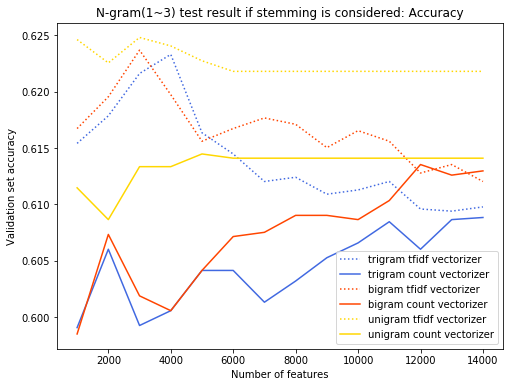

In [46]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg_sw,columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg_sw,columns=['nfeatures','validation_accuracy','test_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_sw,columns=['nfeatures','validation_accuracy','test_accuracy'])

nfeatures_plot_ug_tfidf = pd.DataFrame(feature_result_sw_tfidf,columns=['nfeatures','validation_accuracy','test_accuracy'])
nfeatures_plot_tg_tfidf = pd.DataFrame(feature_result_tg_sw_tfidf,columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_bg_tfidf = pd.DataFrame(feature_result_bg_sw_tfidf,columns=['nfeatures','validation_accuracy','test_accuracy'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg_tfidf.nfeatures, nfeatures_plot_tg_tfidf.validation_accuracy,label='trigram tfidf vectorizer',linestyle=':',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer', color='royalblue')
plt.plot(nfeatures_plot_bg_tfidf.nfeatures, nfeatures_plot_bg_tfidf.validation_accuracy,label='bigram tfidf vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',color='orangered')
plt.plot(nfeatures_plot_ug_tfidf.nfeatures, nfeatures_plot_ug_tfidf.validation_accuracy, label='unigram tfidf vectorizer',linestyle=':',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',color='gold')

plt.title("N-gram(1~3) test result if stemming is considered: Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [47]:
nfeatures_plot_ug_tfidf.sort_values(by='validation_accuracy', ascending=False)

,nfeatures,validation_accuracy,test_accuracy
2,3000,0.624812,0.617581
0,1000,0.624624,0.605560
3,4000,0.624060,0.613824
4,5000,0.622744,0.613073
1,2000,0.622556,0.610819
5,6000,0.621805,0.610068
6,7000,0.621805,0.613073
7,8000,0.621805,0.613073
8,9000,0.621805,0.613073
9,10000,0.621805,0.613073


According to this a maximun number of tokens as **3000** would be enough if using **unigrams** and **stopwords** with tfidf 

(Val. Acc. = 0.624812, Test Acc. = 0.617581) 

**It makes totally sense that if you normalize text with something like Stemming, tf-idf provides better results than bag of words**

# Considering Lemmatization

In [48]:
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text.values, y):
    text_train, text_test = df.cleaned_text_and_lemmatization.values[train_index], df.cleaned_text_and_lemmatization.values[test_index]
    y_train, y_test = y[train_index], y[test_index]    

In [49]:
clas = LogisticRegression()
n_features = np.arange(1000,15000,1000)

feature_result_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features)
feature_result_no_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features, stop_words=stopwordlist)

custom_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:5].index))
feature_result_no_csw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), classifier=clas, n_splits=5, n_features=n_features, stop_words=custom_stop_words)

# also tf-idf with stop words 
feature_result_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), classifier=clas, n_splits=5, n_features=n_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solve

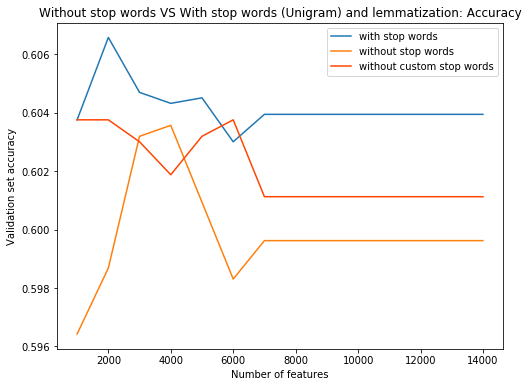

In [50]:
nfeatures_plot_sw = pd.DataFrame(feature_result_sw, columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_no_sw = pd.DataFrame(feature_result_no_sw, columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_no_csw = pd.DataFrame(feature_result_no_csw, columns=['nfeatures','validation_accuracy','test_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_sw.nfeatures, nfeatures_plot_sw.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_no_sw.nfeatures, nfeatures_plot_no_sw.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_no_csw.nfeatures, nfeatures_plot_no_csw.validation_accuracy,label='without custom stop words',color='orangered')

plt.title("Without stop words VS With stop words (Unigram) and lemmatization: Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.show()

In [51]:
nfeatures_plot_sw.sort_values(by='validation_accuracy', ascending=False)

,nfeatures,validation_accuracy,test_accuracy
1,2000,0.606579,0.608565
2,3000,0.604699,0.606311
4,5000,0.604511,0.604808
3,4000,0.604323,0.608565
6,7000,0.603947,0.603306
7,8000,0.603947,0.611570
8,9000,0.603947,0.611570
9,10000,0.603947,0.611570
10,11000,0.603947,0.611570
11,12000,0.603947,0.611570


In [52]:
feature_result_bg_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), ngram_range=(1, 2), n_splits=5, n_features=n_features)
feature_result_tg_sw = nfeature_accuracy_checker(vectorizer=CountVectorizer(), ngram_range=(1, 3), n_splits=5, n_features=n_features)

# doing for tf-idf also
feature_result_bg_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), ngram_range=(1, 2), n_splits=5, n_features=n_features)
feature_result_tg_sw_tfidf = nfeature_accuracy_checker(vectorizer=TfidfVectorizer(), ngram_range=(1, 3), n_splits=5, n_features=n_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solve

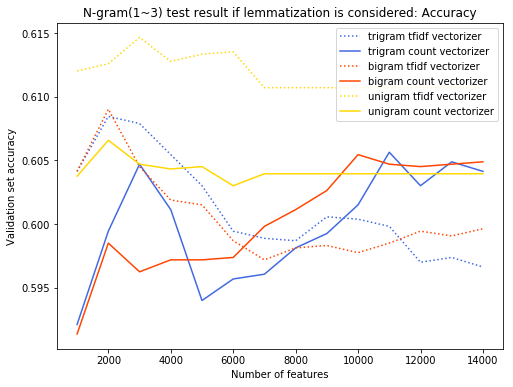

In [53]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg_sw,columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg_sw,columns=['nfeatures','validation_accuracy','test_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_sw,columns=['nfeatures','validation_accuracy','test_accuracy'])

nfeatures_plot_ug_tfidf = pd.DataFrame(feature_result_sw_tfidf,columns=['nfeatures','validation_accuracy','test_accuracy'])
nfeatures_plot_tg_tfidf = pd.DataFrame(feature_result_tg_sw_tfidf,columns=['nfeatures','validation_accuracy', 'test_accuracy'])
nfeatures_plot_bg_tfidf = pd.DataFrame(feature_result_bg_sw_tfidf,columns=['nfeatures','validation_accuracy','test_accuracy'])


plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg_tfidf.nfeatures, nfeatures_plot_tg_tfidf.validation_accuracy,label='trigram tfidf vectorizer',linestyle=':',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer', color='royalblue')
plt.plot(nfeatures_plot_bg_tfidf.nfeatures, nfeatures_plot_bg_tfidf.validation_accuracy,label='bigram tfidf vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',color='orangered')
plt.plot(nfeatures_plot_ug_tfidf.nfeatures, nfeatures_plot_ug_tfidf.validation_accuracy, label='unigram tfidf vectorizer',linestyle=':',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',color='gold')

plt.title("N-gram(1~3) test result if lemmatization is considered: Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [54]:
nfeatures_plot_ug_tfidf.sort_values(by='validation_accuracy', ascending=False)

,nfeatures,validation_accuracy,test_accuracy
2,3000,0.614662,0.616078
5,6000,0.613534,0.613073
4,5000,0.613346,0.613073
3,4000,0.612782,0.613824
1,2000,0.612594,0.621337
0,1000,0.612030,0.616078
6,7000,0.610714,0.611570
7,8000,0.610714,0.612322
8,9000,0.610714,0.612322
9,10000,0.610714,0.612322


According to this a maximun number of tokens as **3000** would be enough if using **unigrams** and **stopwords** with tfidf and lemmatization 

(Val. Acc. = 0.614662, Test Acc. = 0.616078) 

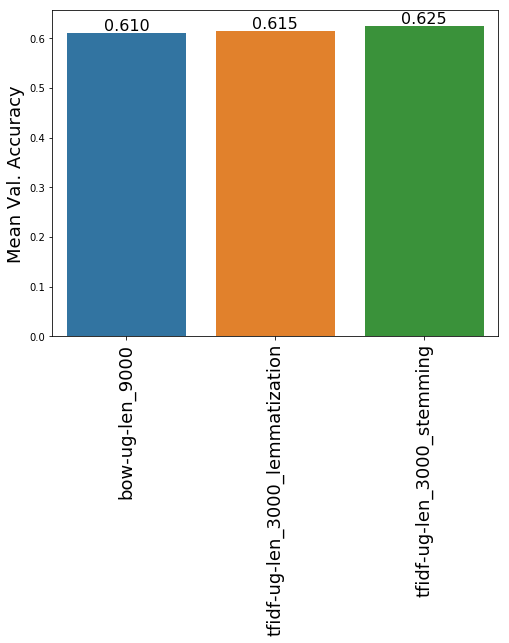

In [55]:
plt.figure(figsize=(8, 6))
names, val_scores = ['bow-ug-len_9000','tfidf-ug-len_3000_lemmatization','tfidf-ug-len_3000_stemming'], [0.609774,0.614662,0.624812]
ax = sns.barplot(x=names, y=val_scores)

total = 3
for p, score in zip(ax.patches, val_scores):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.005,
            '{:1.3f}'.format(score),
            ha="center", fontsize=16) 

plt.ylabel('Mean Val. Accuracy', fontsize=18)
plt.xticks(rotation=90, fontsize=18)
plt.show()

# Putting all together in the baseline model
   * Will consider stemming
   * Will do some hyperparameter tuning for the linear regression classifier and check again the best combination of parameters for the vectorizer
   * Checking confusion matrix for the test set 

In [56]:
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text_and_stemming.values, y):
    text_train, text_test = df.cleaned_text_and_stemming.values[train_index], df.cleaned_text_and_stemming.values[test_index]
    y_train, y_test = y[train_index], y[test_index]   

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.5s finished


Best Parameters after tuning with gridsearch: {'classifier__C': 1, 'vectorizer__min_df': 5}

Null accuracy: 51.24%
Mean accuracy score : 62.52%
accuracy in test set : 60.86%
model is 11.28% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix in Test Set

          predicted_negative  predicted_neutral  predicted_positive
negative  580                 84                 18                
neutral   212                 168                36                
positive  97                  74                 62                


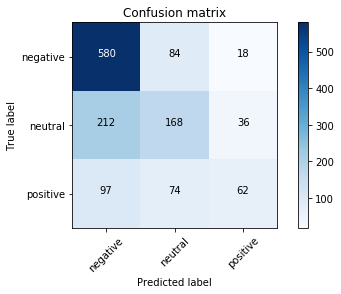

--------------------------------------------------------------------------------
Classification Report in Test Set

             precision    recall  f1-score   support

   negative       0.65      0.85      0.74       682
    neutral       0.52      0.40      0.45       416
   positive       0.53      0.27      0.36       233

avg / total       0.59      0.61      0.58      1331



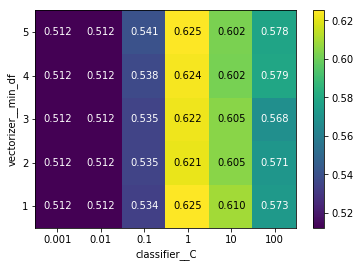

In [57]:
cvec = TfidfVectorizer(max_features=3000)

pipeline = Pipeline([
        ('vectorizer', cvec),
        ('classifier', LogisticRegression())
        ])

param_grid = {"vectorizer__min_df": np.arange(1,6),
              "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
              }

grid = train_test_and_evaluate(pipeline, text_train, y_train, text_test, y_test, n_splits=5, param_grid=param_grid)
plot_gridsearch_heatmap2D(grid, 'classifier__C', 'vectorizer__min_df')

# Dealing with Imbalanced Learning
   + The high class imbalance problem may imply that standard classifiers will be overwhelmed by the large classes and ignore the small ones.
   + Taking into account that oversampling the minority class can result in overfitting problems if we oversample before cross-validating. Therefore you need to fit the pipeline only with the training set split after cross-validation split and not before
   + Considering RandomOverSampler, SMOTE (Synthetic Minority Over-Sampling Technique) and ADASYN methods

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=.2, random_state=0)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    pos_prec = []
    pos_recall = []
    pos_f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        
        accuracy.append(scores)
        precision.append(precision_score(Y[test], prediction, average=average_method))
        print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        pos_prec.append(precision_score(Y[test], prediction, average=None)[2])
        recall.append(recall_score(Y[test], prediction, average=average_method))
        pos_recall.append(recall_score(Y[test], prediction, average=None)[2])
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method))
        pos_f1.append(f1_score(Y[test], prediction, average=None)[2])
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print('\n Overall metrics :')
    print("accuracy: %.2f (+/- %.2f)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f (+/- %.2f)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f (+/- %.2f)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f (+/- %.2f)" % (np.mean(f1), np.std(f1)))
    
    print('\n Metrics for the minority class \'positive\'')
    print("precision: %.2f (+/- %.2f)" % (np.mean(pos_prec), np.std(pos_prec)))
    print("recall: %.2f (+/- %.2f)" % (np.mean(pos_recall), np.std(pos_recall)))
    print("f1 score: %.2f (+/- %.2f)" % (np.mean(pos_f1), np.std(pos_f1)))

In [59]:
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text.values, y):
    text_train, text_test = df.cleaned_text_and_stemming.values[train_index], df.cleaned_text_and_stemming.values[test_index]
    y_train, y_test = y[train_index], y[test_index]   

In [60]:
tvec = TfidfVectorizer(stop_words=None, max_features=3000, ngram_range=(1,1))
lr = LogisticRegression()

In [61]:
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

In [62]:
lr_cv(5, text_train, y_train, original_pipeline, 'macro')

              negative    neutral     positive
precision: [ 0.66428571  0.52631579  0.64285714]
recall:    [ 0.85321101  0.42042042  0.33870968]
f1 score:  [ 0.74698795  0.46744574  0.44366197]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.64850136  0.51984127  0.64102564]
recall:    [ 0.8733945   0.39339339  0.2688172 ]
f1 score:  [ 0.74433151  0.44786325  0.37878788]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.64092141  0.52892562  0.5952381 ]
recall:    [ 0.86788991  0.38438438  0.2688172 ]
f1 score:  [ 0.73733437  0.44521739  0.37037037]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.66757493  0.54761905  0.57692308]
recall:    [ 0.89908257  0.41441441  0.24193548]
f1 score:  [ 0.76622361  0.47179487  0.34090909]
--------------------------------------------------
              negati

In the umbalanced data the recall for the minor class ('positive') is quite low

In [63]:
import imblearn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=251017),lr)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=251017),lr)
ADASYN_pipeline = make_pipeline(tvec, ADASYN(ratio='minority',random_state=251017),lr)

In [64]:
lr_cv(5, text_train, y_train, ROS_pipeline, 'macro')

              negative    neutral     positive
precision: [ 0.73320158  0.50798722  0.4244898 ]
recall:    [ 0.68073394  0.47747748  0.55913978]
f1 score:  [ 0.70599429  0.49226006  0.48259861]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.75722543  0.51838235  0.41758242]
recall:    [ 0.72110092  0.42342342  0.61290323]
f1 score:  [ 0.7387218   0.4661157   0.49673203]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.73624288  0.49829352  0.42622951]
recall:    [ 0.71192661  0.43843844  0.55913978]
f1 score:  [ 0.7238806   0.46645367  0.48372093]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.73664825  0.47368421  0.41525424]
recall:    [ 0.73394495  0.40540541  0.52688172]
f1 score:  [ 0.73529412  0.4368932   0.46445498]
--------------------------------------------------
              negati

In [65]:
lr_cv(5, text_train, y_train, ADASYN_pipeline, 'macro')

              negative    neutral     positive
precision: [ 0.70790378  0.56164384  0.36904762]
recall:    [ 0.7559633   0.24624625  0.66666667]
f1 score:  [ 0.73114463  0.34237996  0.47509579]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.71571906  0.62931034  0.37142857]
recall:    [ 0.7853211   0.21921922  0.69892473]
f1 score:  [ 0.74890639  0.32516704  0.48507463]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.68602826  0.55555556  0.39383562]
recall:    [ 0.80183486  0.22522523  0.61827957]
f1 score:  [ 0.7394247   0.32051282  0.48117155]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.71608833  0.59848485  0.39261745]
recall:    [ 0.83302752  0.23723724  0.62903226]
f1 score:  [ 0.77014419  0.33978495  0.48347107]
--------------------------------------------------
              negati

In [66]:
lr_cv(5, text_train, y_train, SMOTE_pipeline, 'macro')

              negative    neutral     positive
precision: [ 0.73852295  0.5125      0.43209877]
recall:    [ 0.67889908  0.49249249  0.56451613]
f1 score:  [ 0.70745698  0.50229709  0.48951049]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.75142315  0.52325581  0.41218638]
recall:    [ 0.7266055   0.40540541  0.61827957]
f1 score:  [ 0.73880597  0.45685279  0.49462366]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.7266055   0.51140065  0.45754717]
recall:    [ 0.7266055   0.47147147  0.52150538]
f1 score:  [ 0.7266055   0.490625    0.48743719]
--------------------------------------------------
              negative    neutral     positive
precision: [ 0.73001776  0.4795539   0.42672414]
recall:    [ 0.75412844  0.38738739  0.53225806]
f1 score:  [ 0.74187726  0.42857143  0.47368421]
--------------------------------------------------
              negati

According to these results is better to use a SMOTE oversampling technique since with little impact in overall accuracy we gain a little bit in the F1 score. Moreover, notice that the recall for positive tweets is higher than in the original umbalanced data.

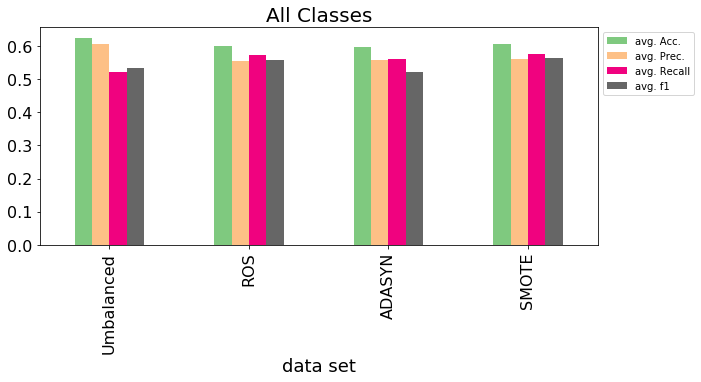

In [67]:
data_sets = ['Umbalanced', 'ROS', 'ADASYN', 'SMOTE']
avg_accuracy = [.6248, .6013, .5964, .6071]
avg_precision = [.6059, .5551, .5591, .5605]
avg_recall = [.5217, .5716, .5606, .5748]
avg_f1 = [.5339, .5592, .5222, .5637]

data = pd.DataFrame({'data_sets':data_sets,'avg. Acc.':avg_accuracy, 'avg. Prec.':avg_precision, 'avg. Recall':avg_recall,
                    'avg. f1':avg_f1})

data.index = data.data_sets ; data.drop(['data_sets'], axis=1, inplace=True)
ax = data.plot.bar(figsize=(10,4),fontsize=16, colormap='Accent')
plt.xlabel('data set', fontsize=18)
plt.title('All Classes', fontsize= 20)
ax.legend(bbox_to_anchor=(1., 1))

In [ ]:
data_sets = ['Umbalanced', 'ROS', 'ADASYN', 'SMOTE']
avg_precision = [.63, .43, .39, .44]
avg_recall = [0.29, .56, .65, .56]
avg_f1 = [.39, .49, .49, .49]

data = pd.DataFrame({'data_sets':data_sets,'avg. Prec.':avg_precision, 'avg. Recall':avg_recall, 'avg. f1':avg_f1})

data.index = data.data_sets ; data.drop(['data_sets'], axis=1, inplace=True)
ax = data.plot.bar(figsize=(10,4),fontsize=16, colormap='Set1')
plt.xlabel('data set', fontsize=18)
plt.title('Minor Class (i.e. \'Positive class\')', fontsize= 20)
ax.legend(bbox_to_anchor=(1., 1))

All the oversampling techniques provides better f1-score by about 10 points for the minor class but in terms of overall accuracy the initial umbalanced data set is doing better and gain in f1 is of just about 3 points in case of SMOTE.

# Comparing different methods for classification
   + Considering tfidf and stemming and no oversampling

In [69]:
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text_and_stemming.values, y):
    text_train, text_test = df.cleaned_text_and_stemming.values[train_index], df.cleaned_text_and_stemming.values[test_index]
    y_train, y_test = y[train_index], y[test_index] 

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

In [71]:
def cv_imbalanced_split(model, X, y, n_iter=5, test_size=0.2):

    # with StratifiedShuffleSplit we try to reproduce class imbalance
    scores = []
    for train, val in StratifiedShuffleSplit(n_splits=n_iter, test_size=test_size).split(X, y):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_val), y_val))
        
    #print('Accuracy per CV fold:')
    #print(', '.join(['%.3f' % x for x in scores]))
    #print('\n')
    
    return scores


def compare_classifiers(X_train, y_train, X_test, y_test, classifiers, cv=5, 
                        test_size=0.2, vectorizer=TfidfVectorizer()):
    # given list of models do a benchmark
    unsorted_scores = []
    
    for name, model in classifiers:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model)
        ])
        #print('Model {}'.format(name))
        scores = cv_imbalanced_split(checker_pipeline, X_train, y_train, n_iter=cv)
        #repdicting for the test set
        test_score = accuracy_score(checker_pipeline.fit(X_train, y_train).predict(X_test), y_test)
        score_tupple = (name, np.mean(scores), np.std(scores), np.min(scores), np.max(scores), test_score, scores)
        unsorted_scores.append(score_tupple)

    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    print (tabulate([x[:-1] for x in scores], floatfmt=".3f", 
                    headers=('model', 'Mean Val. Accuracy', 'Std Val. Accuracy', 'min', 'max', 'Test set Accuracy')))
    
    return scores


def print_scores(unsorted_scores):
    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    print (tabulate([x[:-1] for x in scores], floatfmt=".3f", 
                    headers=("model", 'Mean Val. Accuracy', 'Std Val. Accuracy', 'min', 'max', 'Test set Accuracy')))

    
def plot_scores(scores):
    plt.figure(figsize=(15, 6))
    names, val_scores = [name for name,_,_,_,_,_,_ in scores], [score for _, score,_,_,_,_,_ in scores]
    ax = sns.barplot(x=names, y=val_scores)
    
    for p, score in zip(ax.patches, val_scores):
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.005,
                '{:1.3f}'.format(score),
                ha="center", fontsize=14) 
        
    plt.xlabel('method', fontsize=18)
    plt.ylabel('Mean Val. Accuracy', fontsize=18)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()         

model                          Mean Val. Accuracy    Std Val. Accuracy    min    max    Test set Accuracy
---------------------------  --------------------  -------------------  -----  -----  -------------------
LogisticRegression                          0.612                0.009  0.600  0.625                0.618
BernoulliNB                                 0.606                0.011  0.585  0.617                0.585
RidgeClassifier                             0.597                0.014  0.569  0.620                0.598
LinearSVC with L1-based FS                  0.596                0.007  0.586  0.609                0.589
LinearSVC                                   0.592                0.011  0.572  0.604                0.588
PassiveAggressiveClassifier                 0.579                0.008  0.567  0.593                0.566
MultinomialNB                               0.577                0.008  0.564  0.590                0.577
Gradient_Boosting                           0.

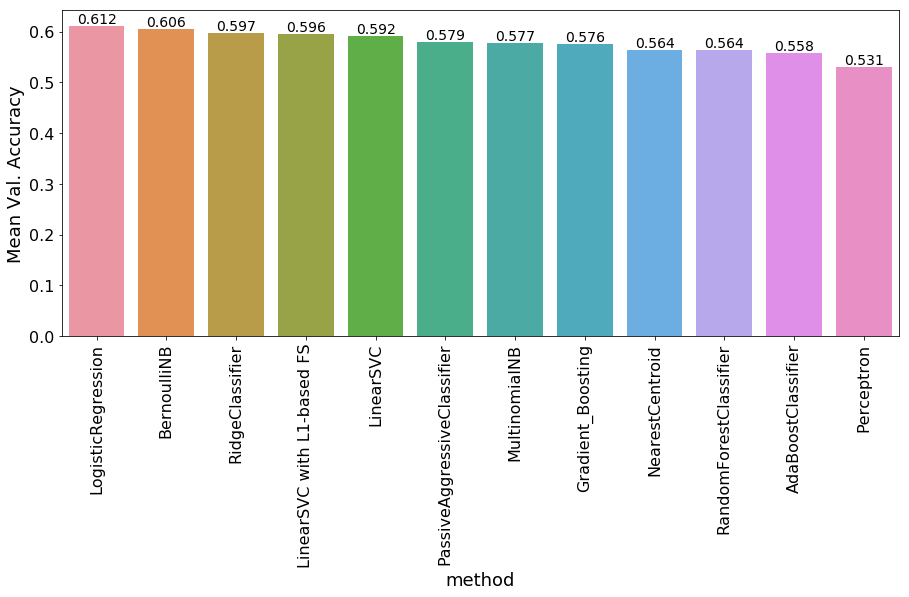

In [72]:
vect = TfidfVectorizer(max_features=3000, stop_words=None, ngram_range=(1,1))

classifiers = [('LogisticRegression', LogisticRegression()),
              ('LinearSVC', LinearSVC()),
              ('LinearSVC with L1-based FS', Pipeline([
                      ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
                      ('classification', LinearSVC(penalty="l2"))])),
              ('MultinomialNB', MultinomialNB()),
              ('BernoulliNB', BernoulliNB()),
              ('RidgeClassifier', RidgeClassifier()),
              ('AdaBoostClassifier', AdaBoostClassifier()),
              ('Perceptron', Perceptron()),
              ('PassiveAggressiveClassifier', PassiveAggressiveClassifier()),
              ('NearestCentroid', NearestCentroid()),
              ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1)),
              ('Gradient_Boosting', xgb.XGBClassifier(objective="multi:softmax", eval_metric='merror', verbose=False))
              ]
               
                   
classifiers_scores = compare_classifiers(text_train, y_train, text_test, y_test, cv=10, classifiers=classifiers, 
                                         vectorizer=vect)
plot_scores(classifiers_scores)

Considering and ensembler classifier by taking votes from the top 4 model from the above result

In [73]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = BernoulliNB()
clf4 = RidgeClassifier()

eclf = VotingClassifier(estimators=[('LogisticRegression', clf1), ('LinearSVC', clf2), ('BernoulliNB', clf3), 
                                    ('RidgeClassifier', clf4)], voting='hard')

checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=3000,ngram_range=(1,1))),
            ('classifier', eclf)
            ])

clf_accuracy_val,clf_accuracy_test = accuracy_summary(checker_pipeline, text_train, y_train, text_test, y_test, 
                                                         n_splits=5)
    
print("Mean Val. Accuracy for the Ensemble Classifier : {0:0.2f}, Accuracy for test set {1:0.2f} ".format( 
                                                                                         clf_accuracy_val,
                                                                                         clf_accuracy_test))

Mean Val. Accuracy for the Ensemble Classifier : 0.63, Accuracy for test set 0.61 


**The VotingClassifier is doing slightly better than individual classifiers**

# Neural Networks

# Word embeddings
Considering classifiers using vector embeddings. Implementing an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [74]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Bidirectional, GRU, Activation, Dense, Input, Dropout, GlobalAveragePooling1D, Embedding, add, GlobalMaxPooling1D, Conv1D
from keras.models import Model
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Activation, GlobalAveragePooling1D, Dense, Embedding, Input, GlobalMaxPooling1D
from keras import metrics
import keras_metrics

early_stopping_monitor = EarlyStopping(patience=5, monitor='val_categorical_accuracy')

Using TensorFlow backend.


In [75]:
y_full = to_categorical(LabelEncoder().fit_transform(df['airline_sentiment'].values))

In [76]:
from nltk.tokenize import WordPunctTokenizer
from gensim.models.word2vec import Word2Vec

tokenizer = WordPunctTokenizer()

In [124]:
def best_train_history(history):
    best_epoch = np.argmax(history.history['val_categorical_accuracy'])
    print('Accuracy (epoch %d): %.4f train, %.4f val' % \
          (best_epoch + 1, history.history['categorical_accuracy'][best_epoch], history.history['val_categorical_accuracy'][best_epoch]))
# (Note that sentiment.model is the state after the last epoch rather than best epoch!
# Use ModelCheckpointer to restore the best epoch.)

def plot_train_history(history):
    plt.figure()
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'])
    plt.show()
    
def vocab_indices_vector(tokens, vocab):
    vector = [0] * seq_cutoff
    if len(tokens) > seq_cutoff:
        # Remove the middle
        tokens = tokens[: seq_cutoff // 2] + ['SINGLE_PADDING_IN_THE_MIDDLE'] + tokens[-seq_cutoff // 2 :]
    for i, t in enumerate(tokens):
        try:
            vector[i] = vocab.index(t) + 1  # reserving 0 for padding
        except:
            pass  # ignore missing words
    return vector


def embedding_matrix(EMBEDDING_DIM, VECTORS, VOCAB):
    # giving embedding vectors and vocabulary returns embedding matrix to be used in keras
    EMBEDDING_DIM = EMBEDDING_DIM
    embedding_matrix = np.zeros((len(VOCAB) + 1, EMBEDDING_DIM))
    for i, word in enumerate(VOCAB):
        embedding_vector = VECTORS.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            # also, [0] is reserved for padding
            embedding_matrix[i + 1] = embedding_vector
    return embedding_matrix


def best_train_history_val(history):
    best_epoch = np.argmax(history.history['val_categorical_accuracy'])
    return best_epoch, history.history['val_categorical_accuracy'][best_epoch]
    
def plot_scores_NNs(unsorted_scores):
    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    plt.figure(figsize=(15, 6))
    names, val_scores = [name for name,_,_,_,_,_,_,_ in scores], [score for _, score,_,_,_,_,_,_ in scores]
    ax = sns.barplot(x=names, y=val_scores)
    
    for p, score in zip(ax.patches, val_scores):
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.005,
                '{:1.3f}'.format(score),
                ha="center", fontsize=14) 
        
    plt.xlabel('method', fontsize=18)
    plt.ylabel('Mean Val. Accuracy', fontsize=18)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

def cv_imbalanced_split_nns(model, name, X, y, X_test, y_test, n_iter=5, test_size=0.2):
    print('Considering model {0}, doing {1} fold CV with validation set size of {2:.0f} %'.format(name, n_iter, 100*test_size))
    # with StratifiedShuffleSplit we try to reproduce class imbalance
    scores = []
    epochs = []
    val_sets = []
    test_scores = []
    
    for train, val in StratifiedShuffleSplit(n_splits=n_iter, test_size=test_size, random_state=0).split(X,y):
        X_train, X_val = list(pd.Series(X)[train]), list(pd.Series(X)[val])
        y_train, y_val = y[train], y[val]
        
        try:
            best_epoch, score = best_train_history_val(model.train(X_train, to_categorical(y_train), X_val, 
                                                         to_categorical(y_val)))
            
            epochs.append(best_epoch)
            scores.append(score)
            val_sets.append([list(pd.Series(X)[val]), y_val])
            # predicting for test set
            test_scores.append(accuracy_score(y_test, model.predict_classes(X_test)))
        except:
            continue       
    
    print('Val. Accuracy')
    #print([(float('{:0.2f}'.format(f[0])), f[1]) for f in zip(scores, epochs)])
    print([float('{0:.2f}'.format(score)) for score in scores])
    #print('\n')
    return epochs, scores, val_sets, test_scores

def becnhmark_nns(X_train, y_train, X_test, y_test, all_models, cv=5, test_size=0.2):
    # given list of models do a benchmark
    #unsorted_scores = [(name, cv_imbalanced_split_nns(model, name, X, y, n_iter=cv, test_size=test_size)) for name, model in all_models]
    unsorted_scores = []
    opt_num_epochs = []
    val_sets_models = {} 
    
    for name, model in all_models:
        epochs_list, scores_list, val_sets, test_scores = cv_imbalanced_split_nns(model, name, X_train, y_train, 
                                                                               X_test, y_test,
                                                                               n_iter=cv, test_size=test_size)
        
        epochs_tupple = (name, epochs_list)
        opt_num_epochs.append(epochs_tupple)
        score_tupple = (name, np.mean(scores_list), np.std(scores_list), 
                        np.min(scores_list), np.max(scores_list), np.mean(test_scores), np.std(test_scores))
        unsorted_scores.append(score_tupple)
        val_sets_models[name]=val_sets
    
    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    print (tabulate([x[:-1] for x in scores], floatfmt=".3f", 
                    headers=("model", 'Mean Val. Accuracy', 'Std Val. Accuracy', 'min', 'max', 'Test set Accuracy')))
        
    return opt_num_epochs, unsorted_scores
    #return opt_num_epochs, scores, val_sets_models

    
def print_scores_NNs(unsorted_scores):
    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    print (tabulate([x[:-1] for x in scores], floatfmt=".3f", 
                    headers=("model", 'Mean Val. Accuracy', 'Std Val. Accuracy', 'min', 'max', 'Mean Test set Accuracy')))

In [99]:
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0).split(df.cleaned_text.values, y):
    text_train, text_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
X_tokens = df['cleaned_text'].apply(lambda x : WordPunctTokenizer().tokenize(x))
all_words = set(w for words in X_tokens for w in words)
print('There are {} different tokens after cleaning text'.format(len(all_words)))
X_tokens_train = text_train['cleaned_text'].apply(lambda x : WordPunctTokenizer().tokenize(x))
X_tokens_test = text_test['cleaned_text'].apply(lambda x : WordPunctTokenizer().tokenize(x))


X_tokens_lemmatization = df['cleaned_text_and_lemmatization'].apply(lambda x : WordPunctTokenizer().tokenize(x))
all_words_lemmatization = set(w for words in X_tokens_lemmatization for w in words)
print('There are {} different tokens after cleaning text and lemmatization'.format(len(all_words_lemmatization)))
X_tokens_lemmatization_train = text_train['cleaned_text_and_lemmatization'].apply(lambda x : WordPunctTokenizer().tokenize(x))
X_tokens_lemmatization_test = text_test['cleaned_text_and_lemmatization'].apply(lambda x : WordPunctTokenizer().tokenize(x))


X_tokens_stemming = df['cleaned_text_and_stemming'].apply(lambda x : WordPunctTokenizer().tokenize(x))
all_words_stemming = set(w for words in X_tokens_stemming for w in words)
print('There are {} different tokens after cleaning text and stemming'.format(len(all_words_stemming)))
X_tokens_stemming_train = text_train['cleaned_text_and_stemming'].apply(lambda x : WordPunctTokenizer().tokenize(x))
X_tokens_stemming_test = text_test['cleaned_text_and_stemming'].apply(lambda x : WordPunctTokenizer().tokenize(x))

There are 11635 different tokens after cleaning text
There are 8972 different tokens after cleaning text and lemmatization
There are 6932 different tokens after cleaning text and stemming


In [100]:
# Definning the size of vectors to be used as input for keras ... you will be padding later on
lengths = sorted([len(token) for token in X_tokens])
percentile = 0.95
seq_cutoff = lengths[int(len(lengths)*percentile)]
print('Longest: %d, Average: %f, Median: %d, %d%% percentile: %d tokens' % (lengths[-1], np.mean(lengths), lengths[int(len(lengths)*0.5)], percentile*100, seq_cutoff))

Longest: 27, Average: 13.395279, Median: 14, 95% percentile: 21 tokens


In [101]:
# Testing for cleaned text 

In [102]:
model_w2v = Word2Vec(X_tokens, size=100, window=5, min_count=2, workers=2)
w2v = {w: vec for w, vec in zip(model_w2v.wv.index2word, model_w2v.wv.syn0)}

model_w2v_lemmatization = Word2Vec(X_tokens_lemmatization, size=100, window=5, min_count=2, workers=2)
w2v_lemmatization = {w: vec for w, vec in zip(model_w2v_lemmatization.wv.index2word, model_w2v_lemmatization.wv.syn0)}

model_w2v_stemming = Word2Vec(X_tokens_stemming, size=100, window=5, min_count=2, workers=2)
w2v_stemming = {w: vec for w, vec in zip(model_w2v_stemming.wv.index2word, model_w2v_stemming.wv.syn0)}

In [103]:
# Keep only most frequent 5000 words rather than all 90000
# Just saving memory - the long tail occurs too few times
# for the model to learn anything anyway

vocab_d = {}
for tweet in X_tokens:
    for token in tweet:
        #print(token)
        if token not in vocab_d:
            vocab_d[token] = 1
        else:
            vocab_d[token] += 1
            
print('number of tokens is {}.'.format(len(vocab_d)))
                      
#vocab = [i[0] for i in sorted(vocab_d.items(), key=lambda value: value[1], reverse=True)[:5000]]  
vocab = [i[0] for i in sorted(vocab_d.items(), key=lambda value: value[1], reverse=True)]     # considering all  


vocab_d = {}
for tweet in X_tokens_lemmatization:
    for token in tweet:
        #print(token)
        if token not in vocab_d:
            vocab_d[token] = 1
        else:
            vocab_d[token] += 1
            
print('number of tokens is {}.'.format(len(vocab_d)))
                      
#vocab = [i[0] for i in sorted(vocab_d.items(), key=lambda value: value[1], reverse=True)[:5000]]  
vocab_lemmatization = [i[0] for i in sorted(vocab_d.items(), key=lambda value: value[1], reverse=True)] # considering all 


vocab_d = {}
for tweet in X_tokens_stemming:
    for token in tweet:
        #print(token)
        if token not in vocab_d:
            vocab_d[token] = 1
        else:
            vocab_d[token] += 1
            
print('number of tokens is {}.'.format(len(vocab_d)))
                      
#vocab = [i[0] for i in sorted(vocab_d.items(), key=lambda value: value[1], reverse=True)[:5000]]  
vocab_stemming = [i[0] for i in sorted(vocab_d.items(), key=lambda value: value[1], reverse=True)]     # considering all 

number of tokens is 11635.
number of tokens is 8972.
number of tokens is 6932.


In [104]:
embedding_w2v_100 = embedding_matrix(100, w2v, VOCAB=vocab)
X_indices = [vocab_indices_vector(x, vocab=vocab) for x in X_tokens]
X_train_indices = [vocab_indices_vector(x, vocab=vocab) for x in X_tokens_train]
X_test_indices = [vocab_indices_vector(x, vocab=vocab) for x in X_tokens_test]

embedding_w2v_100_lemmatization = embedding_matrix(100, w2v_lemmatization, VOCAB=vocab_lemmatization)
X_indices_lemmatization = [vocab_indices_vector(x, vocab=vocab_lemmatization) for x in X_tokens_lemmatization]
X_train_indices_lemmatization = [vocab_indices_vector(x, vocab=vocab_lemmatization) for x in X_tokens_lemmatization_train]
X_test_indices_lemmatization = [vocab_indices_vector(x, vocab=vocab_lemmatization) for x in X_tokens_lemmatization_test]

embedding_w2v_100_stemming = embedding_matrix(100, w2v_stemming, VOCAB=vocab_stemming)
X_indices_stemming = [vocab_indices_vector(x, vocab=vocab_stemming) for x in X_tokens_stemming]
X_train_indices_stemming = [vocab_indices_vector(x, vocab=vocab_stemming) for x in X_tokens_stemming_train]
X_test_indices_stemming = [vocab_indices_vector(x, vocab=vocab_stemming) for x in X_tokens_stemming_test]

In [105]:
print('% of tokens that have no trained w2v word embeddings: {0:.2f}'.format(100. * np.count_nonzero(np.all(embedding_w2v_100 == 0, axis=1)) / len(vocab)))
print('% of tokens that have no trained w2v word embeddings: {0:.2f}'.format(100. * np.count_nonzero(np.all(embedding_w2v_100_lemmatization == 0, axis=1)) / len(vocab_lemmatization)))
print('% of tokens that have no trained w2v word embeddings: {0:.2f}'.format(100. * np.count_nonzero(np.all(embedding_w2v_100_stemming == 0, axis=1)) / len(vocab_stemming))) 

% of tokens that have no trained w2v word embeddings: 59.50
% of tokens that have no trained w2v word embeddings: 58.88
% of tokens that have no trained w2v word embeddings: 52.71


In [106]:
# downloaded pretrained embeddings
w2v_pretrained = {}
with open('SBW-vectors-300-min5.txt', "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding="utf-8")
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            w2v_pretrained[word] = nums
            
len(w2v_pretrained)

embedding_w2v_pretreained = embedding_matrix(300, w2v_pretrained, VOCAB=vocab)

print('% of tokens that have no pre-trained word2vec word embeddings: {0:.2f}'.format(100. * np.count_nonzero(np.all(embedding_w2v_pretreained == 0, axis=1)) / len(vocab)))

% of tokens that have no pre-trained word2vec word embeddings: 14.78


In [107]:
# downloaded pretrained embeddings
w2v_pretrained = {}
with open('SBW-vectors-300-min5.txt', "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding="utf-8")
        if word in all_words_lemmatization:
            nums=np.array(parts[1:], dtype=np.float32)
            w2v_pretrained[word] = nums
            
len(w2v_pretrained)

embedding_w2v_pretreained_lemmatization = embedding_matrix(300, w2v_pretrained, VOCAB=vocab_lemmatization)

print('% of tokens that have no pre-trained word embeddings after lemmatization: {0:.2f}'.format(100. * np.count_nonzero(np.all(embedding_w2v_pretreained_lemmatization == 0, axis=1)) / len(vocab_lemmatization)))

% of tokens that have no pre-trained word embeddings after lemmatization: 19.10


In [108]:
from sklearn.utils import class_weight

y = LabelEncoder().fit_transform(df['airline_sentiment'].values)

class_weight = class_weight.compute_class_weight('balanced',np.unique(y),y)

class_weight

array([ 0.65091016,  1.06586538,  1.90300429])

In [125]:
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_categorical_accuracy')


class AvgSentimentModel(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', 
                           metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input')                    
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, 
                                 weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        avg_embedded = GlobalAveragePooling1D()(seq_embedded)
        sentiment = Dense(3, activation='sigmoid')(avg_embedded)
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/AvgSentimentModel.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor],
                              shuffle=True,
                              )          

    def predict(self, X, filepath='models/AvgSentimentModel.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/AvgSentimentModel.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')


class HiddenMaxSentimentModel(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                          metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input')                    
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        seq_hidden = Dense(N, activation='tanh')(seq_embedded)
        max_hidden = GlobalMaxPooling1D()(seq_hidden)
        sentiment = Dense(3, activation='sigmoid')(max_hidden)
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/HiddenMaxSentimentModel.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor], shuffle=True,
                              )          

    def predict(self, X, filepath='models/HiddenMaxSentimentModel.hdf5'):
            self.model.load_weights(filepath)
            return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/HiddenMaxSentimentModel.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')

    
    
class CNNSentimentModel(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, size=3, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, size, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                          metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, size, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        seq_conv = Conv1D(N, size, activation='tanh')(seq_embedded)
        max_conv = GlobalMaxPooling1D()(seq_conv)
        hidden_repr = Dense(N, activation='tanh')(max_conv)
        sentiment = Dense(3, activation='sigmoid')(hidden_repr)
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/CNNSentimentModel.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor], shuffle=True,
                              )          

    def predict(self, X, filepath='models/CNNSentimentModel.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/CNNSentimentModel.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')



class CNNSentimentModel_learning_weights(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, size=3, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, size, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                          metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, size, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM,
                                 input_length=seq_cutoff)(seq_indices)
        seq_conv = Conv1D(N, size, activation='relu')(Dropout(0.2)(seq_embedded))
        max_conv = GlobalMaxPooling1D()(seq_conv)
        hidden_repr = Dense(N, activation='relu')(max_conv)
        sentiment = Dense(3, activation='sigmoid')(Dropout(0.2)(hidden_repr))
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/CNNSentimentModel_learning_weights.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor]
                              )          

    def predict(self, X, filepath='models/CNNSentimentModel_learning_weights.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/CNNSentimentModel_learning_weights.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')

    

class GRUSentimentModel(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                          metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        recursive_repr = Bidirectional(GRU(N))(seq_embedded)
        sentiment = Dense(3, activation='sigmoid')(recursive_repr)
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/GRUSentimentModel.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor], shuffle=True,
                              )          
    
    def predict(self, X, filepath='models/GRUSentimentModel.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/GRUSentimentModel.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')
    


class GRUSentimentModel_learning_weights(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                          metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, mask_zero=True)(seq_indices)
        recursive_repr = Bidirectional(GRU(N))(seq_embedded)
        sentiment = Dense(3, activation='sigmoid')(recursive_repr)
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/GRUSentimentModel_learning_weights.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor], shuffle=True,
                              )          
    
    def predict(self, X, filepath='models/GRUSentimentModel_learning_weights.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/GRUSentimentModel_learning_weights.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')
        

            
class CNNGRUSISentimentModel(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, size=3, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, size, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', 
                           metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, size, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        seq_hidden = Dense(N, activation='tanh')(Dropout(0.2)(seq_embedded))
        seq_conv = Conv1D(N, size, activation='tanh', padding='same')(Dropout(0.2)(seq_hidden))
        seq_hidden = add([seq_hidden, seq_conv])
        recursive_repr = Bidirectional(GRU(N))(seq_hidden)
        sentiment = Dense(3, activation='sigmoid', name='sentiment')(recursive_repr) 
        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val=[], y_val=[], filepath='models/CNNGRUSISentimentModel.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor], shuffle=True,
                              )          
  
    def predict(self, X, filepath='models/CNNGRUSISentimentModel.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/CNNGRUSISentimentModel.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')
        
        
class CNNGRUSISentimentModel_learning_weights(object):
    def __init__(self, N, EMBEDDING_DIM, embedding_matrix, size=3, vocab=[]):
        self.model = self.create(N, EMBEDDING_DIM, embedding_matrix, size, vocab)
        #self.model.summary()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                          metrics=[metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall()])
        
    def create(self, N, EMBEDDING_DIM, embedding_matrix, size, vocab):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff)(seq_indices)
        seq_hidden = Dense(N, activation='tanh')(Dropout(0.2)(seq_embedded))
        seq_conv = Conv1D(N, size, activation='tanh', padding='same')(Dropout(0.2)(seq_hidden))
        seq_hidden = add([seq_hidden, seq_conv])
        recursive_repr = Bidirectional(GRU(N))(seq_hidden)
        sentiment = Dense(3, activation='sigmoid', name='sentiment')(recursive_repr) 
        return Model(inputs=[seq_indices], outputs=[sentiment])
    
    def train(self, X, y, X_val=[], y_val=[], filepath='models/CNNGRUSISentimentModel_learning_weights.hdf5'):
        checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        return self.model.fit(np.array(X), y, class_weight=class_weight,
                              epochs=100, 
                              validation_data=(np.array(X_val), y_val),
                              verbose=0,
                              callbacks = [checkpoint, early_stopping_monitor], shuffle=True,
                              )          
  
    def predict(self, X, filepath='models/CNNGRUSISentimentModel_learning_weights.hdf5'):
        self.model.load_weights(filepath)
        return self.model.predict(np.array(X))
        
    def predict_classes(self, X, filepath='models/CNNGRUSISentimentModel_learning_weights.hdf5'):
        proba = self.predict(np.array(X), filepath)
        if proba.shape[-1] > 1:
            return proba.argmax(axis=-1)
        else:
            return (proba > 0.5).astype('int32')

In [ ]:
models_NNs = [
         # for pretrained embeddings
         ("avg_w2v_pre_300D", AvgSentimentModel(64, 300, embedding_w2v_pretreained, vocab=vocab)),
         ("max_w2v_pre_300D", HiddenMaxSentimentModel(64, 300, embedding_w2v_pretreained, vocab=vocab)),
         ("CNN_w2v_pre_300D", CNNSentimentModel(64, 300, embedding_w2v_pretreained, vocab=vocab)),
         ("GRU_w2v_pre_300D", GRUSentimentModel(64, 300, embedding_w2v_pretreained, vocab=vocab)),
         ("CNN_GRU_w2v_300D", CNNGRUSISentimentModel(64, 300, embedding_w2v_pretreained, vocab=vocab)),
         # w2vec 
         ("avg_w2v_100D", AvgSentimentModel(64, 100, embedding_w2v_100, vocab=vocab)),
         ("max_w2v_100D", HiddenMaxSentimentModel(64, 100, embedding_w2v_100, vocab=vocab)),
         ("CNN_w2v_100D", CNNSentimentModel(64, 100, embedding_w2v_100, vocab=vocab)),
         ("GRU_w2v_100D", GRUSentimentModel(64, 100, embedding_w2v_100, vocab=vocab)),
         ("CNN_GRU_w2v_100D", CNNGRUSISentimentModel(64, 100, embedding_w2v_100, vocab=vocab)),
         ("GRU_trainW_100D", GRUSentimentModel_learning_weights(64, 100, embedding_w2v_100, vocab=vocab)),
         ("CNN_trainW_100D", CNNSentimentModel_learning_weights(64, 100, embedding_w2v_100, vocab=vocab)),
         ("CNN_GRU_trainW_100D", CNNGRUSISentimentModel_learning_weights(64, 100, embedding_w2v_100, vocab=vocab)),
        ]

epochs, scores_NNs = becnhmark_nns(X_train_indices, y_train, X_test_indices, y_test, 
                                             all_models=models_NNs, cv=5, test_size=0.2)

Considering model avg_w2v_pre_300D, doing 5 fold CV with validation set size of 20 %
Val. Accuracy
[0.55, 0.59, 0.59, 0.59, 0.6]
Considering model max_w2v_pre_300D, doing 5 fold CV with validation set size of 20 %


In [ ]:
models_NNs_lemmatization = [
         # for pretrained embeddings
         ("avg_w2v_pre_300D_Lem", AvgSentimentModel(64, 300, embedding_w2v_pretreained_lemmatization, vocab=vocab_lemmatization)),
         ("max_w2v_pre_300D_Lem", HiddenMaxSentimentModel(64, 300, embedding_w2v_pretreained_lemmatization, vocab=vocab_lemmatization)),
         ("CNN_w2v_pre_300D_Lem", CNNSentimentModel(64, 300, embedding_w2v_pretreained_lemmatization, vocab=vocab_lemmatization)),
         ("GRU_w2v_pre_300D_Lem", GRUSentimentModel(64, 300, embedding_w2v_pretreained_lemmatization, vocab=vocab_lemmatization)),
         ("CNN_GRU_w2v_300D_Lem", CNNGRUSISentimentModel(64, 300, embedding_w2v_pretreained_lemmatization, vocab=vocab_lemmatization)),
         # w2vec
         ("avg_w2v_100D_Lem", AvgSentimentModel(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("max_w2v_100D_Lem", HiddenMaxSentimentModel(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("CNN_w2v_100D_Lem", CNNSentimentModel(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("GRU_w2v_100D_Lem", GRUSentimentModel(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("CNN_GRU_w2v_100D_Lem", CNNGRUSISentimentModel(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("GRU_trainW_100D_Lem", GRUSentimentModel_learning_weights(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("CNN_trainW_100D_Lem", CNNSentimentModel_learning_weights(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
         ("CNN_GRU_trainW_100D_Lem", CNNGRUSISentimentModel_learning_weights(64, 100, embedding_w2v_100_lemmatization, vocab=vocab_lemmatization)),
          ]

epochs_lemmatization, scores_NNs_lemmatization = becnhmark_nns(X_train_indices_lemmatization, y_train, 
                                                               X_test_indices_lemmatization, y_test, 
                                                               all_models=models_NNs_lemmatization, cv=5, 
                                                               test_size=0.2)

In [ ]:
models_NNs_stemming = [
         ("avg_w2v_100D_Stem", AvgSentimentModel(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("max_w2v_100D_Stem", HiddenMaxSentimentModel(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("CNN_w2v_100D_Stem", CNNSentimentModel(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("GRU_w2v_100D_Stem", GRUSentimentModel(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("CNN_GRU_w2v_100D_Stem", CNNGRUSISentimentModel(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("GRU_trainW_100D_Stem", GRUSentimentModel_learning_weights(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("CNN_trainW_100D_Stem", CNNSentimentModel_learning_weights(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
         ("CNN_GRU_trainW_100D_Stem", CNNGRUSISentimentModel_learning_weights(64, 100, embedding_w2v_100_stemming, vocab=vocab_stemming)),
          ]

epochs_stemming, scores_NNs_stemming = becnhmark_nns(X_train_indices_stemming, y_train, 
                                                               X_test_indices_stemming, y_test, 
                                                               all_models=models_NNs_stemming, cv=5, 
                                                               test_size=0.2)

In [ ]:
plot_scores_NNs(scores_NNs_stemming)